In [8]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [9]:
with open("/mnt/sauce/littlab/users/kuangzy/DSOSD/examples/diff_DSOSD.txt", 'r') as f: 
    diff_dsosd = [float(line.rstrip('\n')) for line in f]
with open("/mnt/sauce/littlab/users/kuangzy/IIIC_SPaRCNet/SPaRCNet/diff_sparcnet.txt",'r') as f:
    diff_sparcnet = [float(line.rstrip('\n')) for line in f]
with open("/mnt/sauce/littlab/users/kuangzy/diff_baseline.txt",'r') as f:
    diff_baseline = [float(line.rstrip('\n')) for line in f]
info_df = pd.read_csv('/mnt/sauce/littlab/users/kuangzy/revised_emu_seizure_sheet.csv')
info_df['abs_sparcnet'] = info_df['sparcnet'].abs()
info_df['abs_dsosd'] = info_df['dsosd'].abs()
info_df['abs_base'] = info_df['baseline'].abs()
info_df.replace('!!!', 'unknown', inplace=True)

# violin plots

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
def vplots(type):
# First, define a hue column based on latency sign
    info_df['Latency'] = info_df['sparcnet'].apply(lambda x: 'Early' if x < 0 else 'Late')
    fig, axes = plt.subplots(1,3,figsize=(15, 5), sharey=False)
    sns.violinplot(
        ax = axes[1],
        x=type,        # group by this
        y='abs_sparcnet',               # what you're plotting
        hue='Latency',        # split violins by this
        data=info_df,
        split=True,
        inner='quart'
        #palette={'Early': 'skyblue', 'Late': 'salmon'}
    )
    info_df['Latency'] = info_df['dsosd'].apply(lambda x: 'Early' if x < 0 else 'Late')
    sns.violinplot(
        ax = axes[2],
        x=type,        # group by this
        y='abs_dsosd',               # what you're plotting
        hue='Latency',        # split violins by this
        data=info_df,
        split=True,
        inner='quart'
        #palette={'Early': 'skyblue', 'Late': 'salmon'}
    )
    info_df['Latency'] = info_df['baseline'].apply(lambda x: 'Early' if x < 0 else 'Late')
    sns.violinplot(
        ax = axes[0],
        x=type,        # group by this
        y='abs_base',               # what you're plotting
        hue='Latency',        # split violins by this
        data=info_df,
        split=True,
        inner='quart'
        #palette={'Early': 'skyblue', 'Late': 'salmon'}
    )
    axes[0].set_ylabel('Onset Latency')
    axes[1].set_xlabel('SPaRCNet')
    axes[1].set_ylabel('')
    axes[2].set_xlabel('DSOSD')
    axes[2].set_ylabel('')
    axes[0].set_xlabel('Baseline')
    axes[0].grid(True)
    axes[1].grid(True)
    axes[2].grid(True)
    axes[0].set_ylim(-500,1500)
    axes[1].set_ylim(-500,1500)
    axes[2].set_ylim(-500,1500)
    if type == 'epitype':
        plt.suptitle('Latency Distribution by Epilepsy Type (Early vs Late)')
    if type == 'epiloc':
        plt.suptitle('Latency Distribution by Epilepsy Localization (Early vs Late)')
    if type == 'epilat':
        plt.suptitle('Latency Distribution by Epilepsy Lateralization (Early vs Late)')
    plt.tight_layout()
    plt.show() 


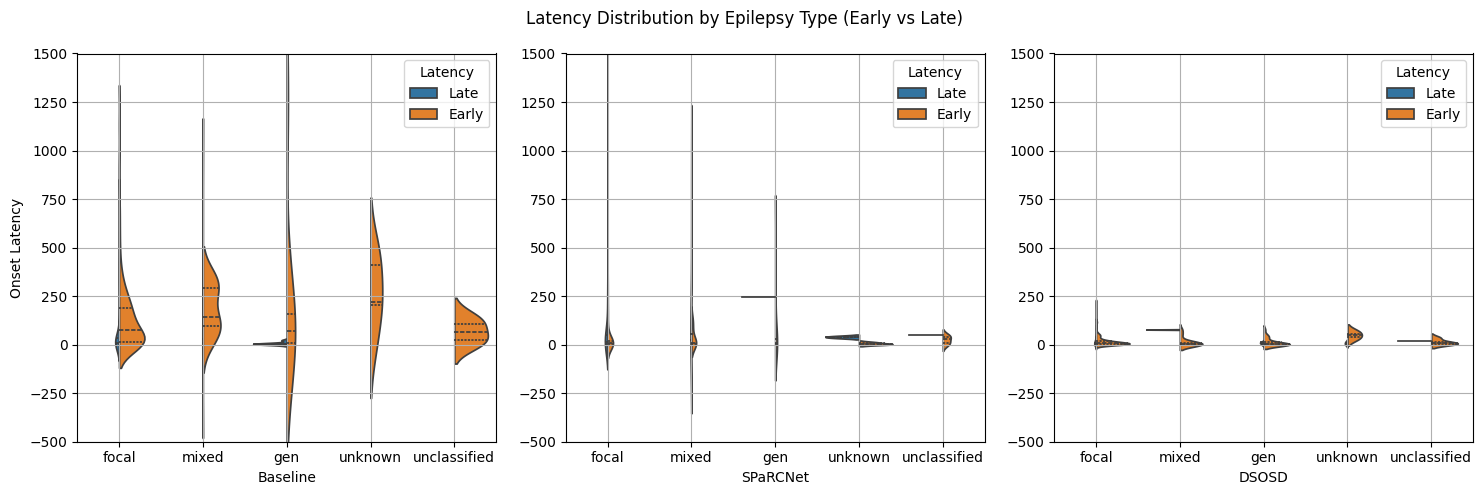

In [11]:
vplots('epitype')

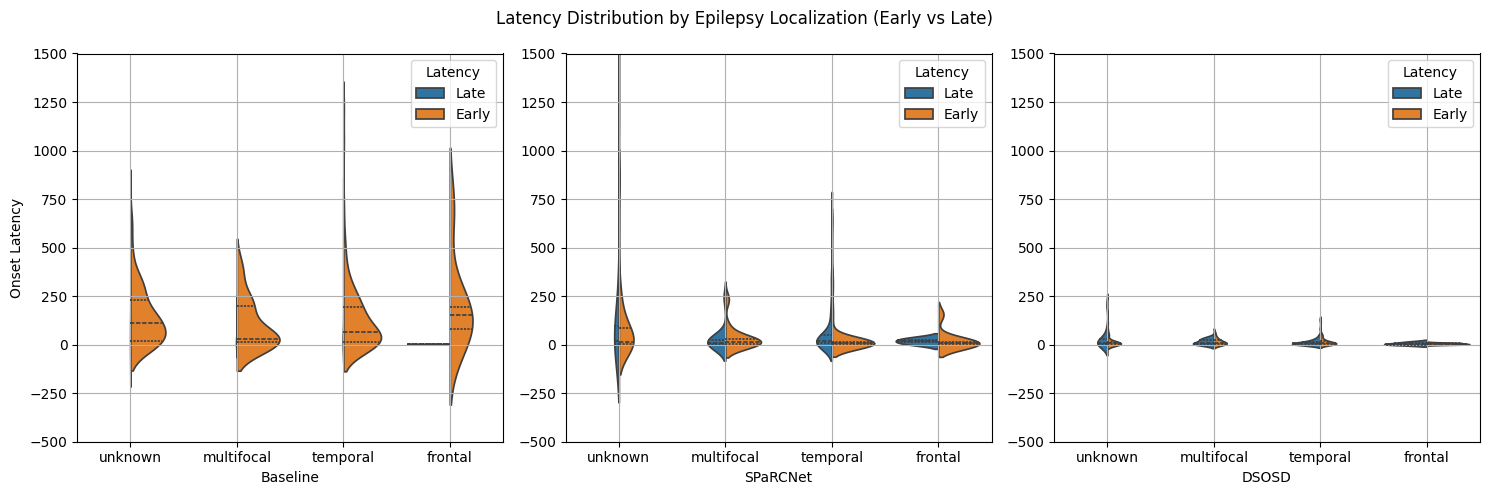

In [13]:
vplots('epiloc')

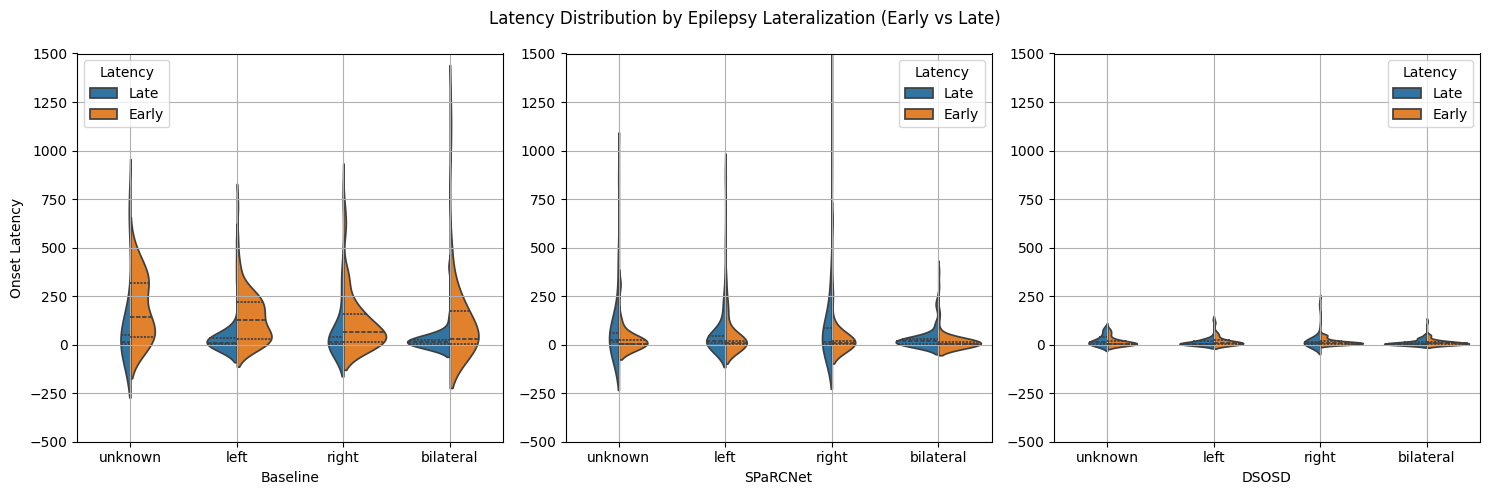

In [14]:
vplots('epilat')

# Kruskal-Wallis tests

In [17]:
from itertools import combinations
from scipy.stats import mannwhitneyu
import statsmodels.stats.multitest as smm
from scipy.stats import kruskal

feature_group = 'epitype'
model = 'sparcnet'
# Group the data
groups = [group[model].dropna().values for name, group in info_df.groupby(feature_group)]

# Run Kruskal-Wallis H-test
stat, p = kruskal(*groups)

print(f'results of {model} w.r.t. {feature_group}')
print('-------------------------------------')
print(f"Kruskal-Wallis H = {stat:.3f}, p = {p:.4f}")


grouped = info_df.groupby(feature_group)
pairs = list(combinations(grouped.groups.keys(), 2))
results = []

for g1, g2 in pairs:
    data1 = grouped.get_group(g1)[model]
    data2 = grouped.get_group(g2)[model]
    stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
    results.append((g1, g2, p))

# Adjust for multiple comparisons
p_vals = [r[2] for r in results]
_, p_corrected, _, _ = smm.multipletests(p_vals, method='fdr_bh')

for (g1, g2, _), p_corr in zip(results, p_corrected):
    print(f"{g1} vs {g2}: corrected p = {p_corr:.4f}")

results of sparcnet w.r.t. epitype
-------------------------------------
Kruskal-Wallis H = 20.086, p = 0.0005
focal vs gen: corrected p = 0.0003
focal vs mixed: corrected p = 0.4321
focal vs unclassified: corrected p = 0.4321
focal vs unknown: corrected p = 0.6595
gen vs mixed: corrected p = 0.0397
gen vs unclassified: corrected p = 0.8364
gen vs unknown: corrected p = 0.1021
mixed vs unclassified: corrected p = 0.4321
mixed vs unknown: corrected p = 0.8364
unclassified vs unknown: corrected p = 0.6009


# plot onset time difference